# Using Pretrained Pipeline from Spark NLP for Sentiment Analysis

Install PySpark and Spark NLP Libraries

In [ ]:
# Install the pyspark package to write Spark applications using Python
# This line installs the Spark NLP package, an NLP library built on top of Apache Spark.
# Downloads the script file colab.sh from the specified URL and immediately executes it using bash
# Script is designed to set up a Colab environment with specific versions of PySpark and Spark NLP
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2023-12-16 18:40:45--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2023-12-16 18:40:46--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.16K  --.-KB/s    in 0s      

2023-12-16 18:40:46 (76.5 MB/s) - written to stdout [1191/1191]

Installing

Import Required Libaries and Methods

In [ ]:
# Imports the main PySpark library, providing access to functionalities for distributed computing.
import pyspark
# Creates and manages SparkSession, which is the entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession
# Imports Window functions for defining window specifications in DataFrame operations
from pyspark.sql.window import Window
# Imports the functions module from PySpark SQL, allowing access to various built-in functions for DataFrame operations
from pyspark.sql import functions as F
# Imports specific functions commonly used in DataFrame operations
from pyspark.sql.functions import col, regexp_replace, count, isnan, when, expr
# Imports the Pipeline class for assembling multiple stages into a single workflow.
from pyspark.ml import Pipeline
# Used to evaluate multiclass classification models based on different metrics like accuracy, precision, recall, etc.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
# Importing various data types for PySpark DataFrame columns
from pyspark.sql.types import ArrayType, IntegerType, StringType, DoubleType

# Imports the Spark NLP library, enabling access to functionalities for NLP
import sparknlp
# Import various classes, methods, and utilities from Spark NLP for base functionalities,
# common components, and annotators
from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

Initiate SparkContext and SparkSession and Import Google Drive Module

In [ ]:
# Initiates a SparkContext and a SparkSession using the Spark NLP library
spark = sparknlp.start()

# Check version of the Spark NLP library and Apache Spark being used in the
# current Spark session
print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 5.2.0
Apache Spark version: 3.2.3


In [ ]:
# This line imports the drive module from the google.colab library
from google.colab import drive
# Mounts your Google Drive into the Colab environment at the specified directory path /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


Function Definition: Converting CSV to DataFrame

In [ ]:
# Method to convert CSV to pandas DataFrame
def csv_to_df(file_path):
    """
      Converts a CSV file to a pandas DataFrame

      Parameters:
         filePath: The path to the CSV file, to be converted into a pandas DataFrame

      Returns:
         df: The newly created pandas DataFrame
    """

    # File location and type
    file_type = "csv" # Specify that the file type is a CSV. Other file types will be ignored.

    # CSV options
    infer_schema = "true" # Infer schema automatically while reading the CSV
    first_row_is_header = "true" # Treat the first row as header
    delimiter = "," # Define the delimiter used in the CSV file

   # Read the CSV file into a DataFrame using Spark
   # Allowing multiline entries in the CSV
   # Specifying an escape character for CSV entries
    df = spark.read.format(file_type) \
         .option("inferSchema", infer_schema) \
         .option("header", first_row_is_header) \
         .option("sep", delimiter) \
         .option("multiline","True") \
         .option("escape","\"") \
         .load(file_path)

    # Return DataFrame
    return df

Load CSV of Reviews from Google Drive

In [ ]:
labeled_data_fileName = "500-combined-reviews.csv"
file_path = "/content/drive/My Drive/ENSF-612/project-files/michael-2nd-attempt/" + labeled_data_fileName
labeled_reviews = csv_to_df(file_path)
labeled_reviews.show()

+----------+------------+-----+-----------+-------------+--------------------+--------+
|listing_id|          id| date|reviewer_id|reviewer_name|            comments|   label|
+----------+------------+-----+-----------+-------------+--------------------+--------+
|  30760930|   4.6495E17|44472|  393558848|       Vedran|Great place to st...|Positive|
|  19670926|  5.45457E17|44583|  298988889|      Jessica|Very friendly sta...|Positive|
|   1436172| 4.0195688E7|42214|   26275433|        Steve|Paul greeted us i...|Positive|
|   1436177| 6.1524319E7|42405|   33548804|        Fiona|Paul made us very...|Positive|
|   2126708| 1.1719182E7|41742|   13309664|    Katherine|Staying at this v...|Positive|
|   3855375| 5.5345498E8|43762|  299045505|        Joely|Great price and g...|Positive|
|   2659707| 5.5056253E7|42335|   49116216|     Weihsuan|It was a great fi...|Positive|
|   4748665|   8.2814E17|44973|  284499594|         Kurt|Appartment was sp...|Positive|
|   5266466|4.68360423E8|43628| 

Exploratory Data Analysis

Here, we want to verify that our dataset does have 500 rows of reviews, no duplicates, has 331 positive reviews, 90 neutral reviews, and 79 negative reviews.

In [ ]:
# Get the number of rows
num_rows = labeled_reviews.count()

# Get the number of columns
num_columns = len(labeled_reviews.columns)

# Display the shape (number of rows and columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)

Number of rows:  500
Number of columns:  7


In [ ]:
# Count the original number of rows
original_count = labeled_reviews.count()

# Remove duplicates and count the remaining rows
distinct_count = labeled_reviews.dropDuplicates().count()

# Calculate the count of duplicate rows
duplicate_count = original_count - distinct_count

# Display the count of duplicate rows
print("Number of duplicate rows: ", duplicate_count)

Number of duplicate rows:  1


In [ ]:
# Show the counts for each sentiment class in the labeled data
label_counts = labeled_reviews.groupBy("label").count()
label_counts.show()

+--------+-----+
|   label|count|
+--------+-----+
|Positive|  330|
| Neutral|   90|
|Negative|   80|
+--------+-----+



In [ ]:
!pip install matplotlib pandas
import matplotlib.pyplot as plt

Let's visualize the distribution of our review labels in bar and pie charts:

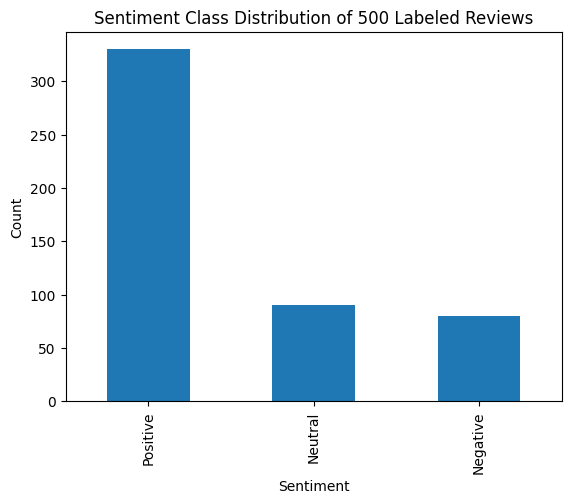

In [ ]:
# Create DataFrame of label counts
label_counts_df = label_counts.toPandas()

# Plot the label counts in a bar graph
label_counts_df.plot(kind='bar', x='label', y='count', legend=False)
plt.title('Sentiment Class Distribution of 500 Labeled Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

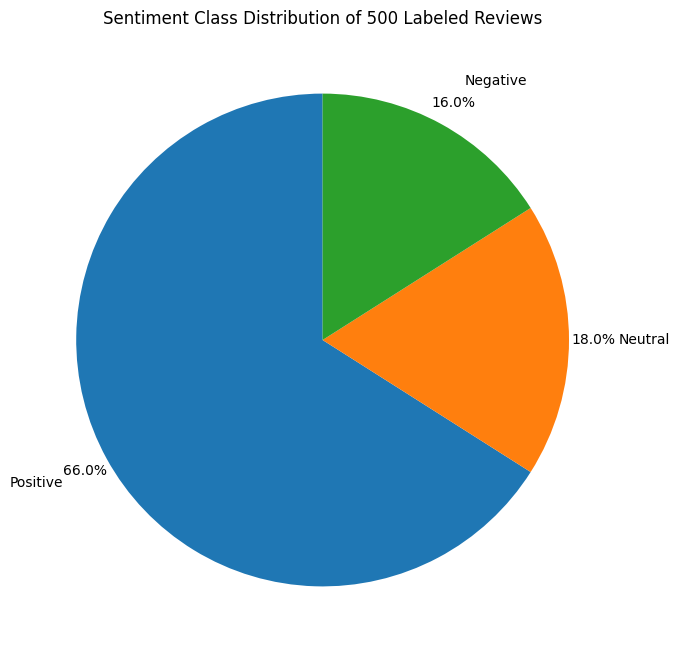

In [ ]:
# Plot the label counts in a pie graph
plt.figure(figsize=(8, 8))
plt.pie(label_counts_df['count'], labels=label_counts_df['label'], autopct='%1.1f%%', pctdistance=1.1, labeldistance=1.2, startangle=90)
plt.title('Sentiment Class Distribution of 500 Labeled Reviews')
plt.show()

As expected, the majority of our 500 reviews are positive. It accounts for two-thirds of the dataset and demonstrates that most customers have generally had a positive experience with Airbnbs in London.

Rename the comments column to "text", so that it can be used in the PretrainedPipeline model

In [ ]:
# Rename comments column to text
labeled_reviews = labeled_reviews.withColumnRenamed("comments", "text")

Load the Pre-trained Sentiment Analysis Pipeline from Spark NLP, which includes a Model Trained on IMDB Reviews

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

# Load the pre-trained sentiment analysis pipeline
# Universal sentence encoder embeddings and trained on IMDB reviews
pretrained_pipeline = PretrainedPipeline('analyze_sentimentdl_use_imdb', lang='en')

analyze_sentimentdl_use_imdb download started this may take some time.
Approx size to download 935.7 MB
[OK!]


The Universal Sentence Encoder used by this model in this pipeline makes getting sentence level embeddings as easy, as it encodes text into vectors used for text classification tasks.

Let's apply this pipeline to transform our labeled dataset:

In [ ]:
# Apply the pipeline to the data
predictions_pretrained = pretrained_pipeline.transform(labeled_reviews)


In [ ]:
# Show the result for the predictions
predictions_pretrained.select("text", "label").show(truncate=60)

+------------------------------------------------------------+--------+
|                                                        text|   label|
+------------------------------------------------------------+--------+
|Great place to stay in London, location very convenient t...|Positive|
|Very friendly staff, all staff I came across was welcomin...|Positive|
|Paul greeted us immediately, with a warm welcome and a co...|Positive|
|Paul made us very welcome - good communication and was th...|Positive|
|Staying at this venue was brilliant! One could not ask fo...|Positive|
|Great price and great location. Modern, clean accommodati...|Positive|
|It was a great first experience with Airbnb! Katherine & ...|Positive|
|Appartment was spotless clean and felt like home. Richard...|Positive|
|                     Great place and incredibly nice people!|Positive|
|Yasmin is awesome and she’s very committed to being a goo...|Positive|
|clean room, nice amenities, friendly host. What's not to ...|Po

Evaluate Performance of the PretrainedPipeline

In [ ]:
# Extract predicted label and probabilities and create new columns
predictions_pretrained = predictions_pretrained.withColumn("predicted_sentiment", predictions_pretrained.sentiment.result[0]
                        ).withColumn("positive_confidence", predictions_pretrained.sentiment.metadata[0].getItem('pos')
                        ).withColumn("negative_confidence", predictions_pretrained.sentiment.metadata[0].getItem('neg'))


In [ ]:
predictions_pretrained.select("text", "label", "predicted_sentiment", "positive_confidence", "negative_confidence").show(truncate=60)

+------------------------------------------------------------+--------+-------------------+-------------------+-------------------+
|                                                        text|   label|predicted_sentiment|positive_confidence|negative_confidence|
+------------------------------------------------------------+--------+-------------------+-------------------+-------------------+
|Great place to stay in London, location very convenient t...|Positive|                pos|                1.0|      2.0789234E-14|
|Very friendly staff, all staff I came across was welcomin...|Positive|                pos|                1.0|      2.8501312E-19|
|Paul greeted us immediately, with a warm welcome and a co...|Positive|                pos|                1.0|      2.4071424E-16|
|Paul made us very welcome - good communication and was th...|Positive|                pos|                1.0|      3.4051896E-21|
|Staying at this venue was brilliant! One could not ask fo...|Positive|     

In [ ]:
# Group by the predicted sentiment and count the occurrences
predictions_pretrained_distribution = predictions_pretrained.groupBy("predicted_sentiment").count()

# Show the distribution
predictions_pretrained_distribution.show()

+-------------------+-----+
|predicted_sentiment|count|
+-------------------+-----+
|                pos|  401|
|                neg|   97|
|            neutral|    2|
+-------------------+-----+



It is interesting that the pipeline model barely predicted any neutral labels, as only 2 neutral labels were predicted in the training data set and none were predicted. This indicates that the model used in this pipeline is naturally inclined towards labelling a review as either positive or negative, instead of considering the good and bad nuances of a review to label it neutral.

Define the Accuracy and F1 Score Evaluators

In [ ]:
# Define the accuracy evaluator
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_numeric",
    predictionCol= "predicted_sentiment_numeric",
    metricName="accuracy"
)

# Define the F1 Score evaluator
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_numeric",
    predictionCol= "predicted_sentiment_numeric",
    metricName="f1"
)

Map Labels and Predictions from Strings to Numerical Values

In [ ]:
# Map string labels and predictions to numerical values
# 0 - positive
# 1 - neutral
# 2 - negative
predictions_pretrained = predictions_pretrained.withColumn(
    "label_numeric",
    when(col("label") == "Positive", 2.0)
    .when(col("label") == "Negative", 0.0)
    .otherwise(1.0)
).withColumn(
    "predicted_sentiment_numeric",
    when(col("predicted_sentiment") == "pos", 2.0)
    .when(col("predicted_sentiment") == "neg", 0.0)
    .otherwise(1.0)
)

predictions_pretrained.select("text", "label", "predicted_sentiment", "label_numeric", "predicted_sentiment_numeric").show(truncate=60)

+------------------------------------------------------------+--------+-------------------+-------------+---------------------------+
|                                                        text|   label|predicted_sentiment|label_numeric|predicted_sentiment_numeric|
+------------------------------------------------------------+--------+-------------------+-------------+---------------------------+
|Great place to stay in London, location very convenient t...|Positive|                pos|          2.0|                        2.0|
|Very friendly staff, all staff I came across was welcomin...|Positive|                pos|          2.0|                        2.0|
|Paul greeted us immediately, with a warm welcome and a co...|Positive|                pos|          2.0|                        2.0|
|Paul made us very welcome - good communication and was th...|Positive|                pos|          2.0|                        2.0|
|Staying at this venue was brilliant! One could not ask fo...|

Evaluate Model Accuracy

In [ ]:
# Evaluate the model

# accuracy
accuracy = accuracy_evaluator.evaluate(predictions_pretrained.select("label_numeric", "predicted_sentiment_numeric"))

# f1 score
f1 = f1_evaluator.evaluate(predictions_pretrained.select("label_numeric", "predicted_sentiment_numeric"))

In [ ]:
# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Overall f1: {f1}")

Accuracy: 0.776
Overall f1: 0.7007634460958212


Create a confusion matrix and get metrics for each class

In [ ]:
# Create confusion matrix
# Convert the labels and predicted sentiments to an RDD for MulticlassMetrics
predictionAndLabels = predictions_pretrained.select("predicted_sentiment_numeric", "label_numeric") \
                                  .rdd.map(lambda row: (float(row[0]), float(row[1])))

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Display the confusion matrix
c_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", c_matrix)


# Get metrics for each class
label_mapping = {0.0: "negative", 1.0: "neutral", 2.0: "positive"}
evaluator = MulticlassClassificationEvaluator(predictionCol="predicted_sentiment_numeric", labelCol="label_numeric")
print("\n")  # print new line

# Loop through each class label
for label in label_mapping.keys():
    # Filter the DataFrame for the specific class
    class_df = predictions_pretrained.filter(expr("label_numeric = '{}'".format(label)))

    # Create a new evaluator for the specific class


    precision = round(evaluator.evaluate(class_df, {evaluator.metricName: "weightedPrecision"}), 3)
    recall = round(evaluator.evaluate(class_df, {evaluator.metricName: "weightedRecall"}), 3)
    f1_score = round(evaluator.evaluate(class_df, {evaluator.metricName: "f1"}), 3)

    print("Metrics for {}: Precision={}, Recall={}, F1 Score={}".format(label_mapping[label], precision, recall, f1_score))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[ 62.   2.  16.]
 [ 31.   0.  59.]
 [  4.   0. 326.]]


Metrics for negative: Precision=1.0, Recall=0.775, F1 Score=0.873
Metrics for neutral: Precision=0.0, Recall=0.0, F1 Score=0.0
Metrics for positive: Precision=1.0, Recall=0.988, F1 Score=0.994


Although we would have liked to have seen an accuracy higher than 77.60%, we have to also consider the fact that we are using a pipeline with a pre-trained model that was trained on IMDB reviews (an entirely different use case). With that in mind, we don't think the results are too bad. The overall F1 Score of 0.70 also falls in line with what is generally considered a good F1 score, according to this link: https://spotintelligence.com/2023/05/08/f1-score/

This does generate curiosity: would the performance improve if we used our own custom-built pipeline and a pre-trained model? What if we used models we learned in class, like Random Forest, Naive Bayes, or Logistic Regression?